# Description

In this notebook, I will read and explore the dataset

In [26]:
import os 
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import pyalex
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders

from open_alex_helper import *

In [2]:
PATH_FOLDER_DATA = "/home/thaiv7/Desktop/python-project/scientific_paper/dataset/data"
if not os.path.exists(PATH_FOLDER_DATA):
    os.makedirs(PATH_FOLDER_DATA)

PATH_FILE_CRAW_DATA = os.path.join(PATH_FOLDER_DATA, "arxiv-metadata-oai-snapshot.json")

PATH_FILE_PROCESSED = os.path.join(PATH_FOLDER_DATA, "arxiv_metadata_filtered.parquet")

LIST_CS_CATEGORIES= [
    'cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CV',
    'cs.CR', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS',
    'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC',
    'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA',
    'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS',
    'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD',
    'cs.SE', 'cs.SI', 'cs.SY'
]

In [3]:
with open(PATH_FILE_CRAW_DATA, 'r') as file:
    data = file.readlines()
    
print(f"Total number of lines in the file: {len(data)}")
print(f"Type of data: {type(data)}")

Total number of lines in the file: 2787058
Type of data: <class 'list'>


In [4]:
idx = np.random.randint(0, len(data))

sample = data[idx]
sample = json.loads(sample) 
category = sample.get('categories', '')
print(f"Category of the sample: {category}") 
print(f"Sample data:")
sample

Category of the sample: cs.AR cs.LG
Sample data:


{'id': '2404.04173',
 'submitter': 'Zishen Wan',
 'authors': 'Zishen Wan, Che-Kai Liu, Mohamed Ibrahim, Hanchen Yang, Samuel\n  Spetalnick, Tushar Krishna, Arijit Raychowdhury',
 'title': 'H3DFact: Heterogeneous 3D Integrated CIM for Factorization with\n  Holographic Perceptual Representations',
 'comments': '2024 Design Automation and Test in Europe (DATE); The first two\n  authors have equal contributions',
 'journal-ref': None,
 'doi': None,
 'report-no': None,
 'categories': 'cs.AR cs.LG',
 'license': 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/',
 'abstract': '  Disentangling attributes of various sensory signals is central to human-like\nperception and reasoning and a critical task for higher-order cognitive and\nneuro-symbolic AI systems. An elegant approach to represent this intricate\nfactorization is via high-dimensional holographic vectors drawing on\nbrain-inspired vector symbolic architectures. However, holographic\nfactorization involves iterative computation with

# 1. Read data and save to parquet file

In [15]:
data_df = []

for idx in range(len(data)):
    sample = data[idx]
    sample = json.loads(sample)  

    list_categories = sample.get('categories', '').split(' ')

    if all(cat in LIST_CS_CATEGORIES for cat in list_categories):
        data_df.append(sample)
    
data_df = pd.DataFrame(data_df)
print(f"Shape of the DataFrame: {data_df.shape}")
data_df.sample()

Shape of the DataFrame: (491159, 14)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
67898,1701.08516,Jan van den Heuvel,Jan van den Heuvel and Stephan Kreutzer and Mi...,Model-Checking for Successor-Invariant First-O...,"20 pages, submitted to LICS 2017",None,10.1109/LICS.2017.8005115,None,cs.LO,http://arxiv.org/licenses/nonexclusive-distrib...,A successor-invariant first-order formula is...,"[{'version': 'v1', 'created': 'Mon, 30 Jan 201...",2023-08-15,"[[Heuvel, Jan van den, ], [Kreutzer, Stephan, ..."


# 2. Process data

In [16]:
SELECTED_COLUMNS = ['id', 'submitter', 'authors', 'title', 
                    'journal-ref', 'categories', 'abstract', 'update_date', 'versions']

data_df = data_df[SELECTED_COLUMNS]
print(f"Shape of the DataFrame after selecting columns: {data_df.shape}")
data_df.sample()

Shape of the DataFrame after selecting columns: (491159, 9)


,id,submitter,authors,title,journal-ref,categories,abstract,update_date,versions
39612,1412.1897,Anh Nguyen,"Anh Nguyen, Jason Yosinski, Jeff Clune",Deep Neural Networks are Easily Fooled: High C...,None,cs.CV cs.AI cs.NE,Deep neural networks (DNNs) have recently be...,2015-04-06,"[{'version': 'v1', 'created': 'Fri, 5 Dec 2014..."


## 2.1. Extract latest version

In [30]:
def extract_latest_version_date(versions, target_format="%m-%d-%Y"):
    try:
        latest_version = versions[-1]
        version_date_str = latest_version.get('created')
        version_datetime = datetime.strptime(version_date_str, "%a, %d %b %Y %H:%M:%S %Z")
        return version_datetime.strftime(target_format)
    except Exception as e:
        return "01-01-1970"

In [31]:
data_df['latest_version_date'] = data_df['versions'].apply(lambda x: extract_latest_version_date(x))

## 2.2. Construct url

In this section, we will construct both arvix url and pdf url from `paper_id`

In [35]:
def construct_arvix_paper_url(paper_id):
    base_url = "https://arxiv.org/abs/"
    return f"{base_url}{paper_id}"

def construct_arvix_pdf_url(paper_id):
    base_url = "https://arxiv.org/pdf/"
    return f"{base_url}{paper_id}"

In [36]:
data_df['paper_url'] = data_df['id'].apply(construct_arvix_paper_url)

data_df['pdf_url'] = data_df['id'].apply(construct_arvix_pdf_url)

print(f"Shape of the DataFrame after selecting columns: {data_df.shape}")
data_df.sample()

Shape of the DataFrame after selecting columns: (491159, 12)


,id,submitter,authors,title,journal-ref,categories,abstract,update_date,versions,latest_version_date,paper_url,pdf_url
22741,1301.3816,Francesco Dinuzzo,Francesco Dinuzzo,Learning Output Kernels for Multi-Task Problems,None,cs.LG,Simultaneously solving multiple related lear...,2013-07-02,"[{'version': 'v1', 'created': 'Wed, 16 Jan 201...",01-16-2013,https://arxiv.org/abs/1301.3816,https://arxiv.org/pdf/1301.3816


## 2.3. Only select paper from 2010 until now

In [39]:
year_threshold = 2012
column_name = "latest_version_date"

data_df[column_name] = pd.to_datetime(data_df[column_name], errors='coerce')
data_df = data_df[data_df[column_name].dt.year >= year_threshold]

print(f"Shape of the DataFrame after filtering by year >= {year_threshold}: {data_df.shape}")
data_df.sample()

Shape of the DataFrame after filtering by year >= 2012: (470605, 12)


,id,submitter,authors,title,journal-ref,categories,abstract,update_date,versions,latest_version_date,paper_url,pdf_url
325482,2310.13192,Vincenzo Calderonio,Vincenzo Calderonio,The Opaque Law of Artificial Intelligence,None,cs.AI,The purpose of this paper is to analyse the ...,2025-01-24,"[{'version': 'v1', 'created': 'Thu, 19 Oct 202...",2025-01-23,https://arxiv.org/abs/2310.13192,https://arxiv.org/pdf/2310.13192


# 2.2. Query published data

In this section, we will try to query where this paper is published

In [41]:
paper_title = 'Semi-supervised adversarial discriminative domain adaptation'

sample_data = data_df[data_df['title'].str.contains(paper_title, case=False, na=False)]

sample_data

,id,submitter,authors,title,journal-ref,categories,abstract,update_date,versions,latest_version_date,paper_url,pdf_url
210682,2109.13016,Thai-Vu Nguyen,"Thai-Vu Nguyen, Anh Nguyen, Nghia Le, Bac Le",Semi-Supervised Adversarial Discriminative Dom...,None,cs.CV cs.LG,Domain adaptation is a potential method to t...,2022-10-20,"[{'version': 'v1', 'created': 'Mon, 27 Sep 202...",2022-10-19,https://arxiv.org/abs/2109.13016,https://arxiv.org/pdf/2109.13016


In [42]:
list_authors = sample_data['authors'].apply(lambda x: str(x).split(', ')).tolist()[0]
print(f"List of authors: {list_authors}" + "\n")

first_author = list_authors[0] if list_authors else "No authors found"
print(f"First author: {first_author}")

List of authors: ['Thai-Vu Nguyen', 'Anh Nguyen', 'Nghia Le', 'Bac Le']

First author: Thai-Vu Nguyen


In [43]:
output = get_paper_from_query(paper_title, first_author)

In [44]:
output

{'id': 'https://openalex.org/W4310124887',
 'doi': 'https://doi.org/10.1007/s10489-022-04288-4',
 'title': 'Semi-supervised adversarial discriminative domain adaptation',
 'display_name': 'Semi-supervised adversarial discriminative domain adaptation',
 'relevance_score': 558.36316,
 'publication_year': 2022,
 'publication_date': '2022-11-29',
 'ids': {'openalex': 'https://openalex.org/W4310124887',
  'doi': 'https://doi.org/10.1007/s10489-022-04288-4',
  'pmid': 'https://pubmed.ncbi.nlm.nih.gov/36466775'},
 'language': 'en',
 'primary_location': {'is_oa': True,
  'landing_page_url': 'https://doi.org/10.1007/s10489-022-04288-4',
  'pdf_url': 'https://link.springer.com/content/pdf/10.1007/s10489-022-04288-4.pdf',
  'source': {'id': 'https://openalex.org/S74726891',
   'display_name': 'Applied Intelligence',
   'issn_l': '0924-669X',
   'issn': ['0924-669X', '1573-7497'],
   'is_oa': False,
   'is_in_doaj': False,
   'is_indexed_in_scopus': True,
   'is_core': True,
   'host_organization'

# 3. Explore data

## 3.1. Distribution of paper across topic

In [45]:
list_categories = data_df['categories'].apply(lambda x: x.split(' '))
unique_categories = set(list_categories.explode())
print(f"Unique categories found: {unique_categories}")

Unique categories found: {'cs.MA', 'cs.GT', 'cs.SE', 'cs.DL', 'cs.MS', 'cs.SY', 'cs.CE', 'cs.NE', 'cs.GR', 'cs.CV', 'cs.MM', 'cs.ET', 'cs.IR', 'cs.GL', 'cs.CG', 'cs.CY', 'cs.RO', 'cs.PL', 'cs.NI', 'cs.OH', 'cs.FL', 'cs.HC', 'cs.CL', 'cs.NA', 'cs.LG', 'cs.DS', 'cs.DM', 'cs.DB', 'cs.OS', 'cs.SI', 'cs.LO', 'cs.DC', 'cs.SC', 'cs.SD', 'cs.AR', 'cs.CR', 'cs.CC', 'cs.AI', 'cs.PF'}


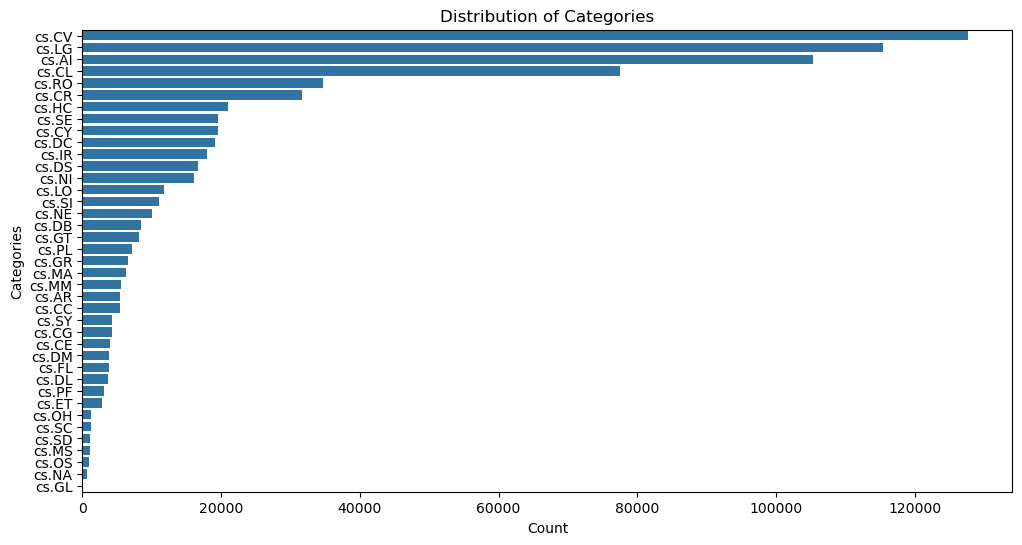

In [46]:
# visualize number of categories
plt.figure(figsize=(12, 6))
sns.countplot(y=list_categories.explode(), order=list_categories.explode().value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.show()

In [47]:
data_df.shape

(470605, 12)

In [48]:
# Save the processed DataFrame
data_df.to_parquet(PATH_FILE_PROCESSED, index=False)
print("Processed data saved to Parquet format.")

Processed data saved to Parquet format.
